In [1]:
import os, re

import discovery as ds
import PTMCMCSampler

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp

Optional mpi4py package is not installed.  MPI support is not available.
Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [37]:
import imp

imp.reload(ds.matrix)
imp.reload(ds.signals)
imp.reload(ds.likelihood)
imp.reload(ds.prior)
imp.reload(ds.pulsar)
imp.reload(ds.prior)
imp.reload(ds)

<module 'discovery' from '/Users/vallis/Documents/discovery/src/discovery/__init__.py'>

In [315]:
# ds.config('numpy')

Read pulsar data

In [3]:
psrfiles = !ls ../data
psrs = [ds.Pulsar.read_feather(f'../data/{psrfile}') for psrfile in psrfiles[:10]
        if '-J' in psrfile or '-B' in psrfile]

Choose the simulation

In [4]:
rndseed = 42

Choose the outpsr

In [5]:
outpsr = 0
outpsrname = psrs[outpsr].name

How many predictive samples?

In [6]:
nsamples = 1

Get the chains

In [6]:
model2a = pd.read_feather('../data/NG15yr-m2a-chain.feather')
model3a = pd.read_feather('../data/NG15yr-m3a-chain.feather')

## Simulate model 2a

In [123]:
Tspan = ds.getspan(psrs)

cbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, variance=1e-14),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan, name='gw', common=['gw_gamma', 'gw_log10_A'])])
                           for ipsr, psr in enumerate(psrs)])

sample = cbl.sample

In [124]:
chain = pd.read_feather('15yr-m2a.feather')

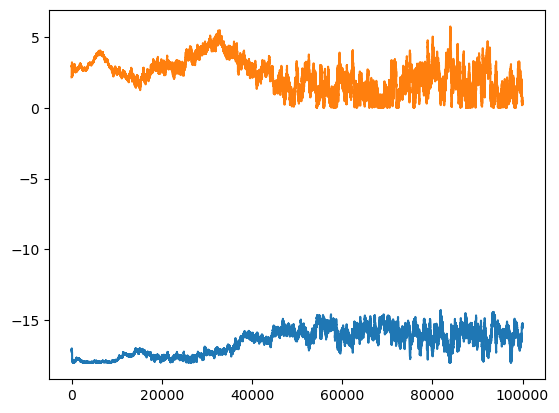

In [134]:
pp.plot(chain['gw_log10_A'])
pp.plot(chain['gw_gamma'])

In [138]:
import random

In [162]:
random.seed(0)

In [163]:
rndseed = random.randint(50000, 100000)

In [164]:
p0 = chain.iloc[ri].to_dict()

In [165]:
key = ds.matrix.jnpkey(rndseed)
key, ysim = sample(key, p0)

In [166]:
dirname = f'sim_m2a_{rndseed}'

In [169]:
os.makedirs(dirname, exist_ok=True) 

In [170]:
for psr, ypsr in zip(psrs, ysim):
    psr.residuals = np.asarray(ypsr)
    psr.save_feather(os.path.join(dirname, f'{psr.name}.feather'), noisedict = psr.noisedict)

In [171]:
!ls {dirname}

B1855+09.feather   J0023+0923.feather J0406+3039.feather J0557+1551.feather
B1937+21.feather   J0030+0451.feather J0437-4715.feather
B1953+29.feather   J0340+4130.feather J0509+0856.feather


In [ ]:
del cbl, sample

## Sample model 2A

In [89]:
psr = psrs[0]

In [95]:
m = ds.makenoise_measurement(psr, psr.noisedict)

In [99]:
rn = ds.makegp_fourier(psr, ds.powerlaw, components=30, T=Tspan, name='red_noise')

In [102]:
gw = ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan, name='gw', common=['gw_gamma', 'gw_log10_A'])

In [109]:
Tspan = ds.getspan(psrs)

m2a = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, variance=1e-14),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan, name='gw', common=['gw_gamma', 'gw_log10_A'])])
                           for ipsr, psr in enumerate(psrs)])

logl = m2a.logL
jlogl = jax.jit(logl)

In [115]:
logprior = ds.makelogprior_uniform(logl.params)
jlogprior = jax.jit(logprior)

In [117]:
p0 = ds.sample_uniform(logl.params)

In [32]:
def x2p(x):
    # does not handle vector parameters
    return {par: val for par, val in zip(logl.params, x)}

def p2x(p):
    return np.array(list(p.values()), 'd')

In [18]:
outdir = './chains'

In [63]:
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [39]:
sampler = PTMCMCSampler.PTMCMCSampler.PTSampler(ndim=len(p0),
                                                logl=lambda x: float(jlogl(x2p(x))),
                                                logp=lambda x: float(jlogprior(x2p(x))),
                                                outDir=outdir, resume=False, cov=np.eye(len(p0)))

In [40]:
sampler.sample(p2x(p0), 10000, thin=10, SCAMweight=10, AMweight=10, DEweight=10)

Finished 100.00 percent in 35.320089 s Acceptance rate = 0.20442
Run Complete


In [72]:
ls chains/

chain_1.txt                          covarianceJumpProposalSCAM_jump.txt
cov.npy                              jumps.txt
covarianceJumpProposalAM_jump.txt


In [80]:
df = pd.read_csv(f'{outdir}/chain_1.txt', delim_whitespace=True, names=logl.params + ['logp','logl','nacc','ptacc'])

In [82]:
df.to_feather(f'{outdir}/chain.feather')

## Conditional probability for RN

In [248]:
Tspan = ds.getspan(psrs)

c2a = ds.GlobalLikelihood((ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, variance=1e-14)])
                           for ipsr, psr in enumerate(psrs)),
                          [ds.makegp_fourier_allpsr(psrs, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                           ds.makegp_fourier_allpsr(psrs, ds.powerlaw, 14, T=Tspan, name='gw', common=['gw_gamma','gw_log10_A'])])

cond = c2a.conditional

In [249]:
p0 = ds.sample_uniform(cond.params)

In [245]:
Tspan = ds.getspan(psrs)

c3a = ds.GlobalLikelihood((ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, variance=1e-14)])
                           for ipsr, psr in enumerate(psrs)),
                          [ds.makegp_fourier_allpsr(psrs, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                           ds.makegp_fourier_global(psrs, ds.powerlaw, ds.hd_orf, 14, T=Tspan, name='gw')])

cond = c3a.conditional

In [246]:
p0 = ds.sample_uniform(cond.params)

In [122]:
psr.pos

[0.23527600482120087, -0.9573531159777988, 0.1676908252796597]

In [ ]:
t, pos

In [ ]:
dd = makedelay(psr, delay, common=[], name='delay'):

## Model-3a conditional predictive for PPL

In [330]:
Tspan = ds.getspan(psrs)

outnoise = ds.makenoise_measurement_simple(psrs[outpsr], {f'{outpsrname}_efac': 1.0,
                                                          f'{outpsrname}_log10_t2equad': 0.0})

gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                outnoise if ipsr == outpsr else ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, variance=1e-14),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise')])
                           for ipsr, psr in enumerate(psrs)],
                          ds.makegp_fourier_global(psrs, ds.powerlaw, ds.hd_orf, 14, T=Tspan, name='gw'))

cond = gbl.conditional

In [13]:
# check that we have all the parameters
# [p for p in cond.params if p not in chain.columns]

outpsr model3a likelihood 

In [293]:
psr = psrs[outpsr]
spl3 = ds.PulsarLikelihood([psr.residuals,
                            ds.makenoise_measurement(psr, psr.noisedict),
                            ds.makegp_ecorr(psr, psr.noisedict),
                            ds.makegp_timing(psr, variance=1e-14),
                            ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                            ds.makegp_fourier_delay(psr, 14, T=Tspan, name='gw'),
                            ds.makegp_fourier_variance(psr, 14, T=Tspan, name='gw')
                            ])

logl3 = spl3.logL
jlogl3 = jax.jit(logl3)

In [294]:
outpsrrange  = slice(outpsr*28, (outpsr+1)*28)

outpsrmean = f'{outpsrname}_gw_mean(28)'
outpsrvar  = f'{outpsrname}_gw_variance(28,28)'

outpsrgamma  = f'{outpsrname}_red_noise_gamma'
outpsrlog10A = f'{outpsrname}_red_noise_log10_A'

In [298]:
def makeppl(logl, chain, conditional=True, accelerate=True):
    index, records = [], []
    for i, row in chain.sample(nsamples).iterrows():
        par = row.to_dict()

        if conditional:    
            cm, cl = cond(par)
            
            par[outpsrmean] = cm[outrange]
            par[outpsrvar] = ds.matrix.jsp.linalg.cho_solve(cl, jnp.identity(len(cm))[:, outrange])[outrange, :]

            if accelerate:
                # could cast this in PulsarLikelihood
                ym = np.array(ds.makegp_fourier_delay(psr, 14, T=Tspan, name='gw')(par))
                spl3 = ds.PulsarLikelihood([psr.residuals - ym,
                                            ds.makenoise_measurement(psr, psr.noisedict),
                                            ds.makegp_ecorr(psr, psr.noisedict),
                                            ds.makegp_timing(psr, variance=1e-14),
                                            ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                            ds.makegp_fourier_variance(psr, 14, T=Tspan, name='gw', noisedict=par)
                                            ])
                
                logl = jax.jit(spl3.logL)
        
        def ufunc(gamma, log10_A):
            return float(logl({**par, outpsrgamma: gamma, outpsrlog10A: log10_A}))
    
        norm = ufunc(4.0, -14.0)
        def nfunc(gamma, log10_A):
            return np.exp(ufunc(gamma, log10_A) - norm)
    
        index.append(i)
        records.append({'gw_gamma': par.get('gw_gamma', np.nan),
                        'gw_log10_A': par['gw_log10_A'],
                                              # note func(y, x), with limits given for x, y
                        'logl': norm + np.log(sp.integrate.dblquad(nfunc, -20, -11, 0, 7)[0])})
    
    return pd.DataFrame(records, index=index)

In [301]:
%time df = makeppl(logl3, model3a, conditional=True, accelerate=True)

CPU times: user 2.94 s, sys: 33.6 ms, total: 2.97 s
Wall time: 1.69 s


In [289]:
%time df = makeppl(logl3, model3a, conditional=True, accelerate=True)

CPU times: user 2.21 s, sys: 36.5 ms, total: 2.25 s
Wall time: 1.23 s


In [ ]:
%time df = makeppl(jlogl3, model3a, conditional=True)

In [ ]:
df.to_feather(f'{outpsrname}_ppl_model3a.feather')

In [ ]:
del spl3, logl3, jlogl3

outpsr model2a likelihood 

In [210]:
spl2 = ds.PulsarLikelihood([psr.residuals,
                            ds.makenoise_measurement(psr, psr.noisedict),
                            ds.makegp_ecorr(psr, psr.noisedict),
                            ds.makegp_timing(psr, variance=1e-14),
                            ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                            ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan, name='gw', common=['gw_log10_A', 'gw_gamma'])
                            ])

logl2 = spl2.logL
jlogl2 = jax.jit(logl2)

In [211]:
%time df = makeppl(logl2, model2a, conditional=False)

CPU times: user 187 ms, sys: 336 ms, total: 523 ms
Wall time: 300 ms


In [ ]:
df.to_feather(f'{outpsrname}_ppl_model2a.feather')

## Check output

In [172]:
ls

15yr-m2a.feather           sample_predictive2a.py
anisotropy.ipynb           sample_predictive3a.py
chains/                    sim_m2a_75247-m2a.feather
conditional.ipynb          sim_model2a_m14p5_42/
examples.ipynb             tfp-jax-experiments.ipynb
flowmc-experiments.ipynb


In [174]:
df = pd.read_feather('sim_m2a_75247-m2a.feather')

In [194]:
sims = ['sim_m2a_53706-m2a',
'sim_m2a_53706-m3a',
'sim_m2a_57001-m2a',
'sim_m2a_57001-m3a',
'sim_m2a_58805-m2a',
'sim_m2a_58805-m3a',
'sim_m2a_61879-m2a',
'sim_m2a_61879-m3a',
'sim_m2a_63695-m2a',
'sim_m2a_63695-m3a',
'sim_m2a_64857-m2a',
'sim_m2a_64857-m3a',
'sim_m2a_65469-m2a',
'sim_m2a_65469-m3a',
'sim_m2a_65595-m2a',
'sim_m2a_65595-m3a',
'sim_m2a_66974-m2a',
'sim_m2a_66974-m3a',
'sim_m2a_71222-m2a',
'sim_m2a_71222-m3a',
'sim_m2a_73692-m2a',
'sim_m2a_73692-m3a',
'sim_m2a_75247-m2a',
'sim_m2a_75247-m3a',
'sim_m2a_79647-m2a',
'sim_m2a_79647-m3a',
'sim_m2a_80343-m2a',
'sim_m2a_80343-m3a',
'sim_m2a_81101-m2a',
'sim_m2a_81101-m3a',
'sim_m2a_84208-m2a',
'sim_m2a_84208-m3a',
'sim_m2a_87447-m2a',
'sim_m2a_87447-m3a',
'sim_m2a_87605-m2a',
'sim_m2a_87605-m3a',
'sim_m2a_90822-m2a',
'sim_m2a_90822-m3a',
'sim_m2a_94376-m2a',
'sim_m2a_94376-m3a',]

In [195]:
sims = [sim.split('-')[0] for sim in sims if 'm3a' in sim]

In [ ]:
# sbatch --export=inputdir="data/sim_m2a_53706",chaindir="runs/sim_m2a_53706",outputdir="runs" run_ppl.sh

In [196]:
for sim in sims:
    print(f'sbatch --export=inputdir="data/{sim}",chaindir="runs/{sim}",outputdir="runs/{sim}-m2a" run_ppl.sh')

sbatch --export=inputdir="data/sim_m2a_53706",chaindir="runs/sim_m2a_53706",outputdir="runs/sim_m2a_53706-m2a" run_ppl.sh
sbatch --export=inputdir="data/sim_m2a_57001",chaindir="runs/sim_m2a_57001",outputdir="runs/sim_m2a_57001-m2a" run_ppl.sh
sbatch --export=inputdir="data/sim_m2a_58805",chaindir="runs/sim_m2a_58805",outputdir="runs/sim_m2a_58805-m2a" run_ppl.sh
sbatch --export=inputdir="data/sim_m2a_61879",chaindir="runs/sim_m2a_61879",outputdir="runs/sim_m2a_61879-m2a" run_ppl.sh
sbatch --export=inputdir="data/sim_m2a_63695",chaindir="runs/sim_m2a_63695",outputdir="runs/sim_m2a_63695-m2a" run_ppl.sh
sbatch --export=inputdir="data/sim_m2a_64857",chaindir="runs/sim_m2a_64857",outputdir="runs/sim_m2a_64857-m2a" run_ppl.sh
sbatch --export=inputdir="data/sim_m2a_65469",chaindir="runs/sim_m2a_65469",outputdir="runs/sim_m2a_65469-m2a" run_ppl.sh
sbatch --export=inputdir="data/sim_m2a_65595",chaindir="runs/sim_m2a_65595",outputdir="runs/sim_m2a_65595-m2a" run_ppl.sh
sbatch --export=inputdir

In [199]:
df2 = pd.read_feather('sim_m2a_53706-m2a.feather')
df3 = pd.read_feather('sim_m2a_53706-m3a.feather')

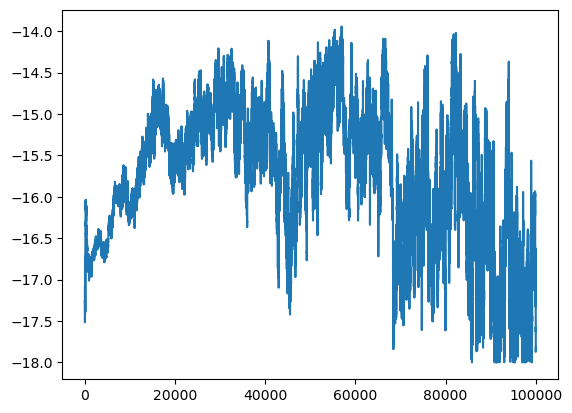

In [212]:
pp.plot(df2.gw_log10_A)

(array([3.66103244e-02, 1.34237856e-01, 2.44068830e-01, 1.20814071e+00,
        3.49018426e+00, 6.74850314e+00, 1.95865236e+01, 5.33290393e+01,
        1.42926707e+02, 3.82480263e+02]),
 array([6.9836115 , 6.98525035, 6.9868892 , 6.98852805, 6.9901669 ,
        6.99180575, 6.9934446 , 6.99508345, 6.9967223 , 6.99836115,
        6.99999999]),
 [<matplotlib.patches.Polygon at 0x356738990>])

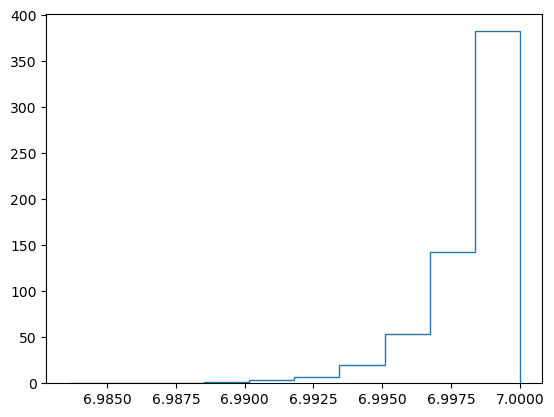

In [209]:
# pp.hist(df2.iloc[50000:].gw_log10_A, histtype='step', density=True)
pp.hist(df3.iloc[50000:].gw_gamma, histtype='step', density=True)

In [233]:
df2 = pd.read_feather('sim_m2a_57001-m2a.feather')
df3 = pd.read_feather('sim_m2a_57001-m3a.feather')

(array([0.01845882, 0.0360786 , 0.0495032 , 0.22234487, 0.46482664,
        0.67458595, 0.77107524, 0.86336933, 1.03956716, 1.05970405,
        1.21324787, 1.12682703, 0.91538964, 0.59152126, 0.42623092,
        0.29869726, 0.50426139, 0.51097369, 0.40357692, 0.22989621,
        0.15018767, 0.07467432, 0.00922941, 0.00839037, 0.05285935,
        0.13592404, 0.13005077, 0.03691764, 0.01845882, 0.05957164,
        0.38344002, 1.58997559, 4.00136866, 6.01254096, 6.57301784,
        5.52338224, 3.69176391, 1.61095153, 0.39686462, 0.07299624]),
 array([-14.60983618, -14.58599981, -14.56216345, -14.53832708,
        -14.51449071, -14.49065435, -14.46681798, -14.44298161,
        -14.41914524, -14.39530888, -14.37147251, -14.34763614,
        -14.32379978, -14.29996341, -14.27612704, -14.25229067,
        -14.22845431, -14.20461794, -14.18078157, -14.15694521,
        -14.13310884, -14.10927247, -14.0854361 , -14.06159974,
        -14.03776337, -14.013927  , -13.99009064, -13.96625427,
      

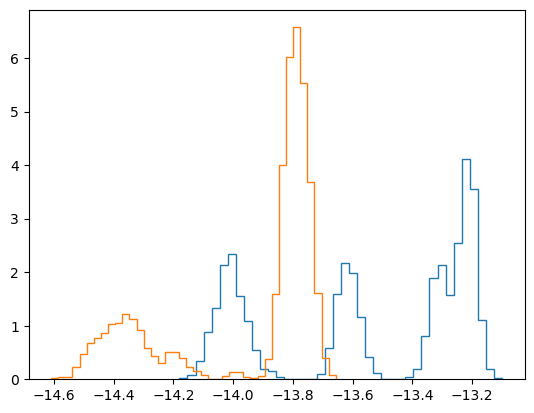

In [234]:
pp.hist(df2.iloc[50000:].gw_log10_A, histtype='step', density=True, bins=40)
pp.hist(df3.iloc[50000:].gw_log10_A, histtype='step', density=True, bins=40)